# Interest of the project

This project solves the Rubik's cube using simulated annealing, which seems possible (https://www.mecs-press.org/ijeme/ijeme-v8-n1/IJEME-V8-N1-1.pdf, https://doi.org/10.1016/j.cpc.2012.03.003). This project does not use the quickest algorithm (check Korf's algorithm, or https://en.wikipedia.org/wiki/Optimal_solutions_for_the_Rubik%27s_Cube), nor the most efficient data structure.

There are two purposes:
- **A practical one:** Practicing programing, reimplementing simulated annealing, exploring data structures for the Rubik's cube, using C++
- **A playful one:** There's a mathematical twist to this project: the Rubik's cube will be mixed and unmixed using the same principle, convergence to the stationary distribution of a Markov chain (only the transition matrix differs). This limit distribution is the uniform distribution when mixing with equiprobable moves, and it becomes $\frac{e^{-\beta E(x)}}{Z(\beta)}$ during the simulated annealing process ($E(x)$ being the *energy* function or *fit* function of the state). As $\beta$ augments, the limit distribution becomes $\delta_{x_{solved}}$.

# The Rubik's cube class

Let's first create a class that implements the Rubik's cube.

Our first implementation is a naive 3d array implementation, with each element of the array along dimension 0 representing a face. It is not the most parcimonious or efficient data structure, but it is convenient for vizualization.

In [1]:
import numpy as np
import copy

In [2]:
def _move(state: np.array, moves) -> None:
  """
  In place functional implementation of the Rubik's cube moves.

  It takes as argument an elementary move:
    F,B,L,R,U,D or their ' (counter-clockwise) version
  It modifies the cube in-place.
  Non-optimal (F' is implemented via FFF).

  Recursive implementation for a list of moves.
  """

  if type(moves) == str: # elementary move
    move = moves
    if move == "F'": # front counter-clockwise
      state[2] = np.rot90(state[2]) # rotates the front face counter-clockwise
      buffer = copy.deepcopy(state [1,:,2]) # stores left segment
      state [1,:,2] = (state [0,2,:].T)[::-1] # moves top segment to the left
      state [0,2,:] = (state [3,:,0].T) # moves right segment to the top
      state [3,:,0] = (state [5,0,:].T)[::-1] # moves bottom segment segment to the right
      state [5,0,:] = buffer.T # moves left segment segment to the bottom
    elif move == "F":
      for i in range(3):
        _move(state,"F'")

    elif move == "B'": # back counter-clockwise
      state[4] = np.rot90(state[4]) # rotates the back face counter-clockwise
      buffer = copy.deepcopy(state [0,0,:]) # stores top segment
      state [0,0,:] = (state [1,:,0].T)[::-1] # moves left segment to the top
      state [1,:,0] = state [5,2,:].T # moves bottom segment to the left
      state [5,2,:] = (state [3,:,2].T)[::-1] # moves right segment to the bottom
      state [3,:,2] = buffer.T # moves top segment to the right
    elif move == "B":
      for i in range(3):
        _move(state,"B'")

    elif move == "L'": # left counter-clockwise
      state[1] = np.rot90(state[1]) # rotates the front face counter-clockwise
      buffer = copy.deepcopy(state [4,:,2]) # stores back segment
      state [4,:,2] = state [0,:,0][::-1] # moves top segment to the back
      state [0,:,0] = state [2,:,0] # moves front segment to the top
      state [2,:,0] = state [5,:,0] # moves bottom segment to the front
      state [5,:,0] = buffer[::-1] # moves back segment to the bottom
    elif move == "L":
      for i in range(3):
        _move(state,"L'")

    elif move == "R'": # right counter-clockwise
      state[3] = np.rot90(state[3]) # rotates the right face counter-clockwise
      buffer = copy.deepcopy(state [0,:,2]) # stores top segment
      state [0,:,2] = state [4,:,0][::-1] # moves back segment to the top
      state [4,:,0] = state [5,:,2][::-1] # moves bottom segment to the back
      state [5,:,2] = state [2,:,2] # moves front segment to the bottom
      state [2,:,2] = buffer # moves top segment to the front
    elif move == "R":
      for i in range(3):
        _move(state,"R'")

    elif move == "U'": # up counter-clockwise
      state[0] = np.rot90(state[0]) # rotates the top face counter-clockwise
      buffer = copy.deepcopy(state [2,0,:]) # stores front segment
      state [2,0,:] = state [1,0,:] # moves left segment to the front
      state [1,0,:] = state [4,0,:] # moves back segment to the left
      state [4,0,:] = state [3,0,:] # moves right segment to the back
      state [3,0,:] = buffer # moves front segment to the right
    elif move == "U":
        for i in range(3):
          _move(state,"U'")

    elif move == "D'": # down counter-clockwise
      state[5] = np.rot90(state[5]) # rotates the down face counter-clockwise
      buffer = copy.deepcopy(state [2,2,:]) # stores front segment
      state [2,2,:] = state [3,2,:] # moves right segment to the front
      state [3,2,:] = state [4,2,:] # moves back segment to the right
      state [4,2,:] = state [1,2,:] # moves left segment to the back
      state [1,2,:] = buffer # moves front segment to the left
    elif move == "D":
      for i in range(3):
        _move(state,"D'")

    elif move == "E":
      return

  else: # list of moves
    for move in moves:
      _move(state,str(move))

In [3]:
def _plot(state: np.array) -> None:
  """
  A vizualization function for the rubik's cube.
  It takes the state array as argument and print a representation of the cube.
  """
  rep = ""
  space = " "

  # top
  top = state[0]
  for i,row in enumerate(top):
    rep += 3*"   "
    for elem in row:
      rep += str(elem)+"  "
    rep += 9*"   " + "\n"

  # sides
  for row in range(3):
    for face in state[1:5]:
      for elem in face[row]:
        rep += str(elem)+"  "
    rep += "\n"

  # bottom
  bottom = state[5]
  for i,row in enumerate(bottom):
    rep += 3*"   "
    for elem in row:
      rep += str(elem)+"  "
    rep += 9*"   " + "\n"

  print(rep)

In [4]:
class RubiksCube():
  """
  This class models a Rubik's cube.

  State representation:
    The data structure chosen is a 3 dimensional array.
    The indexation is: (faces,rows,columns)
    The faces are ordered as: top, left, front, right, back, bottom

  Moves:
    The .move method accepts the standart string notations for the twelve elementary moves:
    F,B,U,D,L,R, and F',B',U',D',L',R' (counter-clockwise equivalents)
  """

  # class variables
  solved_state = np.array([[[i for k in range(3)] for j in range(3)]for i in range(6)])
  moves = ['F','B','L','R','T','D']
  moves += [move+"'" for move in moves]

  # methods

  def __init__(self):
    self.state = copy.deepcopy(RubiksCube.solved_state)

  def move(self, moves) -> None:
    """
    This method modifies the Rubiks cube state by the elementary moves given as argument.
    """
    _move(self.state,moves)

  def plot(self):
    """
    This method plots the current state.
    """
    _plot(self.state)

# Mixing the Rubik's cube

Let's first study how the cube mixes up.

A random mix of the cube can be modeled by a Markov chain whose transition matrix attributes an equal probability to each of the 12 Singmaster's moves.

In July of 2010, Tomas Rokicki, Herbert Kociemba, Morley Davidson, and John Dethridge demonstrated (computationally) that a 3×3×3 Rubik's cube, starting in an arbitrary configuration, can strictly be solved in at most 20 Singmaster moves (Cayley's graph diameter).

This means that the graph distance between two configuration is at most 20 moves.

If we add the "no move" to our 12 Singmaster moves (to have an aperiodic Markov chain), we get:
$$\forall x,y : P^{20}(x,y) \geq \frac{1}{13^{20}}$$

Then using Doeblin minorization:
$$ ||P^{20n}-\mathcal{U}||_{TV} \leq (1 - \frac{1}{13^{20}})^n$$

This is a very slow majoration of the mixing speed.

## Distance proxy

One cannot directly plot the convergence from the dirac distribution toward a uniform distribution.

However, using a proxy of the graph distance, we can try to plot how the distribution spreads over.

We later call those proxies $energy$ functions.

Let's first try using the naive distance:

$$\sum_i \mathbb{1}\{\text{square i not the right color}\}$$

(I don't account for the middle of each face, and I normalize by $6*3^2-6$)

In [5]:
import random

reference_state = RubiksCube().state

def compute_naive_energy(state):
  return sum(sum(sum(state != reference_state)))/(6*3**2-6)

def compute_cube_naive_energy(cube):
  return compute_naive_energy(cube.state)


def step(list_of_cubes, energy_func):
  """
  This function takes as argument a list of cubes.
  It moves each of them by a random move and return the list of energy (evaluated using the energy function).
  """
  energies = []
  for cube in list_of_cubes:
    move = random.choice(RubiksCube.moves)
    cube.move(move)
    energies += [energy_func(cube)]
  return energies

def spread_animation(number_of_cubes, energy_func):
  """
  This function creates the spread animation.
  It takes as an argument the number of cubes that need to be simulated, and the enrgy function used.
  """
  list_of_cubes = [RubiksCube() for i in range(300)]

  def drawframe(n):
    distances = step(list_of_cubes,energy_func)
    n, _ = np.histogram(distances, HIST_BINS)
    for count, rect in zip(n, bar_container.patches):
        rect.set_height(count)
    return bar_container.patches

  return drawframe

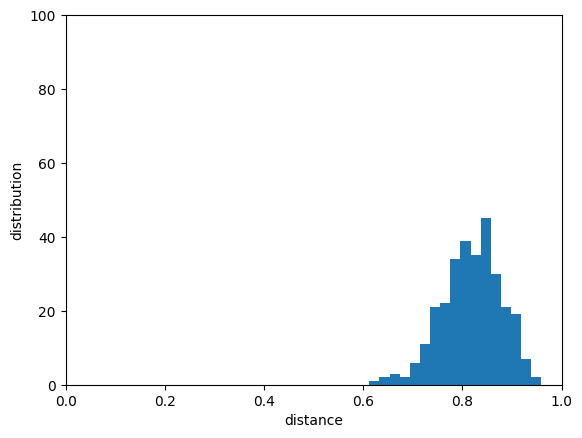

In [6]:
%matplotlib inline

import matplotlib.pyplot as plt
fig, ax = plt.subplots()

# set up
ax.set_xlim(0,1)
ax.set_ylim(0,100)
ax.set_xlabel('distance')
ax.set_ylabel('distribution')

# prime
HIST_BINS = np.linspace(0,1,50)
fake_distribution = [0 for i in range(300)]
_,_,bar_container = ax.hist(fake_distribution,HIST_BINS) # histtype='step'

# compute the animation
from matplotlib import animation
drawframe = spread_animation(500, compute_cube_naive_energy)
anim = animation.FuncAnimation(fig, drawframe, frames=40, interval=100, blit=True)

# convert to video
from IPython.display import HTML
HTML(anim.to_html5_video())

# Generic simulated annealing framework

I implement a generic SA framework:

In [7]:
def sample_neighbour(x: np.array) -> np.array:
  """
  This function returns a random neighbour from the state x.
  """
  x = np.copy(x)
  random_move = str(np.random.choice(RubiksCube().moves))
  _move(x, random_move)
  return x

fit_func = compute_naive_energy

In [8]:
from tqdm import tqdm

def solve_SA(x, sample_neighbour, fit_func, beta_func, length: int):
  """
  This function implements simulated annealing.
  It takes as arguments:
  - an initial state x
  - a neighbour sampling function sample_neighbour
  - an energy fit function fit_func
  - an inverse temperature cooling scheme function beta_func
  (that returns an inverse temperature beta given an integer index)
  - the length of the simulated annealing process (no stop criteria)
  """

  # priming
  fit_list = []
  current_fit = fit_func(initial_state)

  for idx in tqdm(range(length)):
    beta = beta_func(idx)

    # sampler
    new_x = sample_neighbour(x)
    new_fit = fit_func(new_x)

    # accept or reject
    if new_fit <= current_fit:
      x, current_fit = new_x, new_fit
    else:
      acceptance_rate = np.exp(-beta*(new_fit-current_fit))
      if np.random.rand() < acceptance_rate:
        x, current_fit = new_x, new_fit
    fit_list += [current_fit]

  return x, fit_list

# Exploring cooling schemes

## Naive method

Implementation of:
https://www.mecs-press.org/ijeme/ijeme-v8-n1/IJEME-V8-N1-1.pdf

Temperature is decreased by 5% every 1000 moves, which corresponds to the inverse temperature being raised by $\frac{1}{95\%}$ every 1000 moves.

In [9]:
step_length, step_factor = 1000, 1/0.95

def beta_func(idx: int, step_length=500, step_factor=1.1):
  return 1e-2*step_factor**(idx//step_length)

         0  1  5                             
         2  0  5                             
         3  0  1                             
1  1  2  5  3  4  5  2  2  1  0  4  
3  1  0  2  2  4  5  3  1  4  4  5  
1  5  3  0  0  5  3  2  0  3  3  2  
         4  4  4                             
         1  5  3                             
         0  4  2                             



100%|██████████| 1000000/1000000 [02:16<00:00, 7347.40it/s]


         0  2  0                             
         3  0  1                             
         5  0  0                             
1  5  1  4  2  2  3  0  3  4  1  4  
1  1  2  3  2  1  5  3  4  0  4  4  
2  4  1  2  2  2  3  0  4  5  4  0  
         5  5  5                             
         5  5  3                             
         1  3  3                             



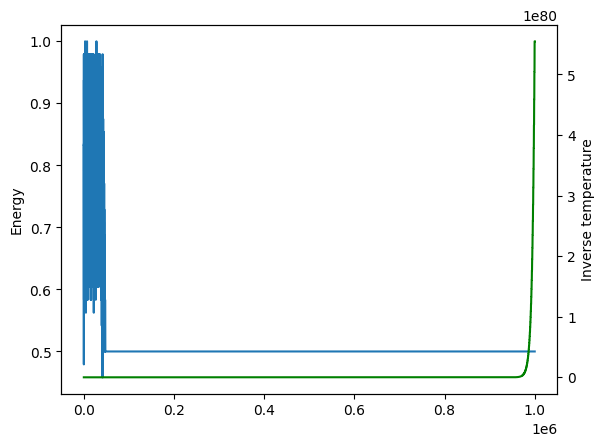

In [10]:
# prime
total_len = int(step_length*1e3)

# mixes
cube = RubiksCube()
for i in range(30):
  random_move = str(np.random.choice(RubiksCube().moves))
  cube.move(random_move)
cube.plot()
initial_state = cube.state

# solve
final_state, fit_list = solve_SA(initial_state, sample_neighbour, fit_func, beta_func, total_len)

fig, ax1 = plt.subplots()
ax1.plot(fit_list)
ax1.set_ylabel("Energy")
ax2 = ax1.twinx()
ax2.plot([beta_func(i) for i in range(total_len)],c="g")
ax2.set_ylabel("Inverse temperature")

# final state
final_cube = RubiksCube()
final_cube.state = final_state
final_cube.plot()

This method fails (even with other more intricate cooling schemes, see down below). From online reading, it actually looks like nobody has been able to reproduce the result from the paper.

## Other cooling schemes

In [11]:
def beta_func(idx):
  return 1e-1*idx**0.6

         3  4  4                             
         2  0  4                             
         3  4  3                             
2  5  2  5  3  5  4  0  5  1  5  0  
5  1  3  0  2  2  0  3  1  0  4  1  
3  3  2  5  4  0  2  2  4  0  5  4  
         1  1  1                             
         2  5  1                             
         0  3  1                             



100%|██████████| 100000/100000 [00:12<00:00, 8223.94it/s]


         0  5  0                             
         0  0  0                             
         0  2  0                             
1  3  1  2  5  2  3  4  3  4  1  4  
3  1  1  4  2  2  1  3  3  5  4  4  
1  3  5  2  1  1  2  4  4  5  0  4  
         3  0  5                             
         2  5  5                             
         5  2  3                             



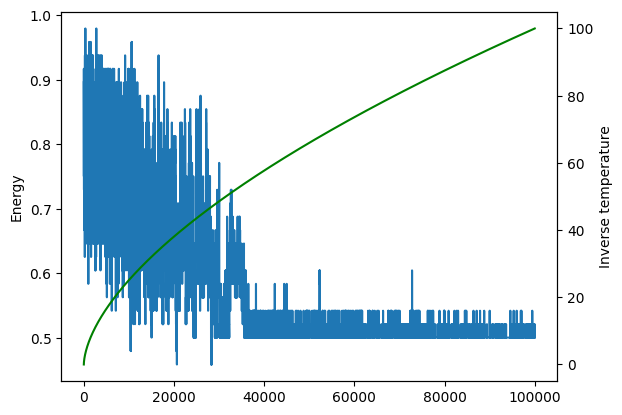

In [12]:
# prime
total_len = int(1e5)

# mixes
cube = RubiksCube()
for i in range(30):
  random_move = str(np.random.choice(RubiksCube().moves))
  cube.move(random_move)
cube.plot()
initial_state = cube.state

# solve
final_state, fit_list = solve_SA(initial_state, sample_neighbour, fit_func, beta_func, total_len)

fig, ax1 = plt.subplots()
ax1.plot(fit_list)
ax1.set_ylabel("Energy")
ax2 = ax1.twinx()
ax2.plot([beta_func(i) for i in range(total_len)],c="g")
ax2.set_ylabel("Inverse temperature")

# final state
final_cube = RubiksCube()
final_cube.state = final_state
final_cube.plot()

In [13]:
def beta_func(idx: int):
  return 20 + 4e-2*idx**0.6 + 20*np.sin(2*np.pi*idx/1e3)

         1  0  4                             
         4  0  2                             
         2  5  2                             
4  3  1  5  2  0  1  3  3  5  2  0  
5  1  1  2  2  0  4  3  3  0  4  3  
1  1  0  4  5  3  2  5  3  5  0  4  
         3  4  0                             
         4  5  1                             
         5  1  2                             



100%|██████████| 100000/100000 [00:12<00:00, 8081.82it/s]


         0  0  3                             
         3  0  5                             
         0  2  3                             
1  4  1  2  1  2  5  1  4  0  3  4  
1  1  5  2  2  4  5  3  3  2  4  4  
1  3  1  2  1  0  3  0  3  4  2  4  
         5  0  2                             
         5  5  4                             
         5  0  5                             



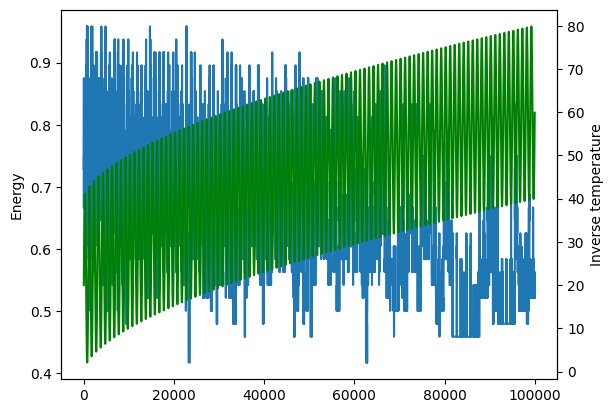

In [14]:
# prime
total_len = int(1e5)

# mixes
cube = RubiksCube()
for i in range(30):
  random_move = str(np.random.choice(RubiksCube().moves))
  cube.move(random_move)
cube.plot()
initial_state = cube.state

# solve
final_state, fit_list = solve_SA(initial_state, sample_neighbour, fit_func, beta_func, total_len)

fig, ax1 = plt.subplots()
ax1.plot(fit_list)
ax1.set_ylabel("Energy")
ax2 = ax1.twinx()
ax2.plot([beta_func(i) for i in range(total_len)],c="g")
ax2.set_ylabel("Inverse temperature")

# final state
final_cube = RubiksCube()
final_cube.state = final_state
final_cube.plot()

# Sequential SA

One way to solve this issue is to solve the cube sequentially (edges, then corners) and to use well-chosen formulae as proposals (first using formulae that modify the edges, then using formulae that modify the corners without affecting the edges).

## Solving the edges - formulae

In [15]:
# formulae to swap UF and UR edges
formula_1 = ["U'", 'L', "U'", "L'", 'U', 'U', 'L', "U'", "L'"]
formula_2 = ["U'", "L", "U'", "L'", "U", "U", "L",
             "U'", "L'", "F", "R'", "F'", "R", "U'", "R", "U", "R'"]

Those two formula swap the UF and UR edges. To consider all 24 contiguous edge couples, one can use the cube's rotations.

> **About the cube's rotations:** Let's explain how all configurations can be attained using the left and down rotations.  
First of all, notice that the front and right face fully determine the cube configuration.  
For a given couple of left and right faces, let's explicit how we attain the corresponding configuration (starting from a random configuration).  
- Case 1: the chosen faces are already "around" the cube (not up or down).
  - Subcase a: They are already ordered (they can directly be attained using from 0 to 3 left rotations).
  - Subcase b: They are wrongly ordered. After using twice the down rotation, they will be rightly ordered. Then use from 0 to 3 left rotations to place them.
- Case 2: one of the face is up or down, the other is left or righ. We use the down rotation, and we are back to case 1.
- Case 3: one of the face is up or down, the other is front or back. We use the left rotation, and we are back to case 2.
  
All cases being exclusive, we have just described the 24 configurations.

In [16]:
# examining all 24 rotations

# left rotation
left_rotation = {
    # unaffected
    "U":"U",
    "D":"D",
    # affected
    "F":"R",
    "B":"L",
    "L":"F",
    "R":"B"
}

initial_keys = list(left_rotation.keys())
for key in initial_keys:
  left_rotation[key+"'"] = left_rotation[key]+"'"

# down rotation
down_rotation = {
    # unaffected
    "L":"L",
    "R":"R",
    # affected
    "F":"D",
    "B":"U",
    "U":"F",
    "D":"B"
}
initial_keys = list(down_rotation.keys())
for key in initial_keys:
  down_rotation[key+"'"] = down_rotation[key]+"'"

In [17]:
def compose_map(map_list: list):
  """This function allows the composition for a list of bijective maps,
  represented as dictionnaries.
  Recursive implementation."""
  assert len(map_list) >= 1
  if len(map_list) == 1:
    return map_list[0]
  elif len(map_list) == 2:
    map_1, map_2 = map_list
    result = {}
    for key in map_1.keys():
      result[key] = map_2[map_1[key]]
    return result
  else:
    map_0 = compose_map(map_list[:2])
    return compose_map([map_0]+map_list[2:])

# case 1, subcase a
left_rotations = [[left_rotation for i in range(j)] for j in range(1,5)]
left_rotations = [compose_map(lr) for lr in left_rotations]

# case 1, subcase b
twice_down = compose_map([down_rotation, down_rotation])
twice_down_left_rotations = [compose_map([twice_down,lr]) for lr in left_rotations]

# case 2, subcase a
down_left_rotations = [compose_map([down_rotation,lr]) for lr in left_rotations]
# case 2, subcase b
three_down_left_rotations = [compose_map([down_rotation,lr]) for lr in twice_down_left_rotations]

# case 3
left_down_left_rotations = [compose_map([left_rotation,lr]) for lr in down_left_rotations]
left_three_down_left_rotations = [compose_map([left_rotation,lr]) for lr in three_down_left_rotations]

# rotations
rotations = (left_rotations + down_left_rotations
             + twice_down_left_rotations + three_down_left_rotations
             + left_down_left_rotations + left_three_down_left_rotations)

In [18]:
# create the list of formulae for the first step of the sequential SA
def apply_rotation_to_formula(formula, rotation):
  return [rotation[move] for move in formula]

edge_formulae = ([apply_rotation_to_formula(formula_1,rotation) for rotation in rotations]
                 + [apply_rotation_to_formula(formula_2,rotation) for rotation in rotations])

## Solving the edges

In [39]:
edges = np.repeat(np.array([[0,1,0],[1,0,1],[0,1,0]])[np.newaxis,...],6,axis=0)

def edge_fit_func(state, edges=edges):
  """This function computes the energy by only considering the edges."""
  return sum(sum(sum(edges*(state != reference_state))))/(4*6)

def sample_neighbour_from_formulae(x,formulae=edge_formulae):
  """
  This function returns a random neighbour from the state x, using the formulae given as argument.
  """
  x = np.copy(x)
  random_formula = np.random.choice(formulae)
  _move(x, random_formula)
  return x

def edge_beta_func(idx: int):
  return idx**0.5

total_len = 5000

In [40]:
# mixes
cube = RubiksCube()
for i in range(30):
  random_move = str(np.random.choice(RubiksCube().moves))
  cube.move(random_move)
cube.plot()
initial_state = cube.state

# solve
final_state, fit_list = solve_SA(initial_state, sample_neighbour_from_formulae, edge_fit_func, edge_beta_func, total_len)

         3  3  0                             
         3  0  4                             
         4  0  4                             
5  5  1  0  2  0  3  1  2  3  2  2  
1  1  3  4  2  1  0  3  5  4  4  5  
2  1  1  5  2  1  0  0  5  3  0  1  
         4  5  2                             
         2  5  4                             
         5  3  4                             



  0%|          | 0/5000 [00:00<?, ?it/s]<ipython-input-39-aea7d6c318c1>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  random_formula = np.random.choice(formulae)
100%|██████████| 5000/5000 [00:04<00:00, 1168.93it/s]


Text(0, 0.5, 'Inverse temperature')

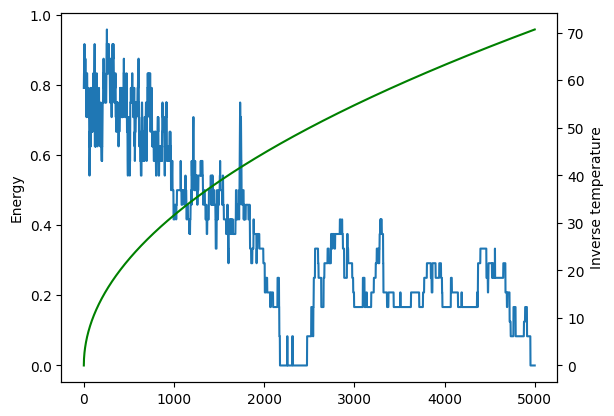

In [41]:
# results
fig, ax1 = plt.subplots()
ax1.plot(fit_list)
ax1.set_ylabel("Energy")
ax2 = ax1.twinx()
ax2.plot([edge_beta_func(i) for i in range(total_len)],c="g")
ax2.set_ylabel("Inverse temperature")

## Solving the corners

In [42]:
formula_1 = ["U", "R", "U'", "L'", "U", "R'", "U'", "L"]
formula_2 = ["L'", "U", "R", "U'", "L", "U", "R'", "U'"]
formula_3 = ["L", "F'", "L'", "B", "L", "F", "L'", "B", "B", "R'", "F", "R", "B", "R'", "F'", "R"]
formula_4 = ["U", "R", "U'", "L'", "U", "R'", "U'", "L", "B", "L'", "D'", "L", "U", "L'", "D", "L", "U'", "B'"]
corner_formulae = ([apply_rotation_to_formula(formula_1,rotation) for rotation in rotations]
                  + [apply_rotation_to_formula(formula_2,rotation) for rotation in rotations]
                  + [apply_rotation_to_formula(formula_3,rotation) for rotation in rotations]
                  + [apply_rotation_to_formula(formula_4,rotation) for rotation in rotations])

In [43]:
# debug
for formula in [formula_1, formula_2, formula_3, formula_4]:
  cube = RubiksCube()
  cube.move(formula)
  cube.plot()

         3  0  1                             
         0  0  0                             
         4  0  0                             
0  1  1  0  2  2  3  3  2  0  4  4  
1  1  1  2  2  2  3  3  3  4  4  4  
1  1  1  2  2  2  3  3  3  4  4  4  
         5  5  5                             
         5  5  5                             
         5  5  5                             

         2  0  1                             
         0  0  0                             
         4  0  0                             
1  1  0  3  2  2  3  3  0  4  4  0  
1  1  1  2  2  2  3  3  3  4  4  4  
1  1  1  2  2  2  3  3  3  4  4  4  
         5  5  5                             
         5  5  5                             
         5  5  5                             

         0  0  0                             
         0  0  0                             
         0  0  0                             
2  1  4  1  2  3  4  3  2  3  4  1  
1  1  1  2  2  2  3  3  3  4  4  4  
1  1  1  2  

In [52]:
corners = np.repeat(np.array([[1,0,1],[0,0,0],[1,0,1]])[np.newaxis,...],6,axis=0)

def corner_fit_func(state, corners=corners):
  """This function computes the energy by only considering the corners."""
  return sum(sum(sum(corners*(state != reference_state))))/(4*6)

def corner_beta_func(idx: int):
  return 5e-2*idx

sample_corner_neighbour = lambda x: sample_neighbour_from_formulae(x, formulae=corner_formulae)

total_len = 2000

In [53]:
# from last step (edges solved)
initial_state = final_state

# solve
final_state, fit_list = solve_SA(initial_state, sample_corner_neighbour, corner_fit_func, corner_beta_func, total_len)

  0%|          | 0/2000 [00:00<?, ?it/s]<ipython-input-39-aea7d6c318c1>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  random_formula = np.random.choice(formulae)
100%|██████████| 2000/2000 [00:02<00:00, 795.93it/s]


Text(0, 0.5, 'Inverse temperature')

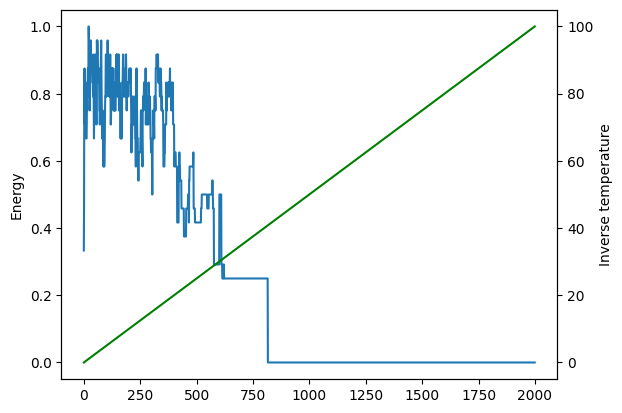

In [54]:
# results
fig, ax1 = plt.subplots()
ax1.plot(fit_list)
ax1.set_ylabel("Energy")
ax2 = ax1.twinx()
ax2.plot([corner_beta_func(i) for i in range(total_len)],c="g")
ax2.set_ylabel("Inverse temperature")

In [55]:
# final state
cube = RubiksCube()
cube.state = final_state
cube.plot()

         0  0  0                             
         0  0  0                             
         0  0  0                             
1  1  1  2  2  2  3  3  3  4  4  4  
1  1  1  2  2  2  3  3  3  4  4  4  
1  1  1  2  2  2  3  3  3  4  4  4  
         5  5  5                             
         5  5  5                             
         5  5  5                             



# To be explored

- Try using a fit function that accounts for the distance of a cubie to its solved position. *Eg: an edge can be one, two or three quarter turn away from its solved position, see the schemes from  https://doi.org/10.1016/j.cpc.2012.03.003 for a graphical explanation.*  
For a simple implementation, I need a new data structure for the cube. One 3d vector for each cubie is not enought as it does not account for the cubies' orientations.
- Link to the Ising model for some energy functions, critical temperature.
- Compare SA to reinforcement learning.